In [1]:
# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook demostrates the linear regression tool used in Symington et al (2017)....

In [2]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio

Populating the interactive namespace from numpy and matplotlib


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [3]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://njs547@130.56.244.105:6432/datacube)>>>

In [4]:
# Define some functions
def geom_query(geom, geom_crs='EPSG:28352'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = zip(*[geom.interpolate(d).coords[0] for d in dist])
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [5]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST

# Here we will investigate the millenium drought

#Define temporal range
start_of_epoch = '2000-01-01'
end_of_epoch =  '2008-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     #'swir1', 
                     'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'

query = {
    'time': (start_of_epoch, end_of_epoch),
}

#query.update(geom_query(geom)) #comment this out if not using a polygon

#If not using a polygon/polyline, enter lat/lon here manually
lat_max = -32.441625
lat_min = -32.54009
lon_max = 142.443514
lon_min = 142.333506
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)

#This accounts for the fact that the shapefile is being incorrectly read
query['crs'] = 'EPSG:4326'


In [6]:
print query

{'y': (-32.441625, -32.54009), 'x': (142.333506, 142.443514), 'crs': 'EPSG:4326', 'time': ('2000-01-01', '2008-12-31')}


## Retrieve surface reflectance data


In [7]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [8]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
            

In [9]:
print sensor1_nbar


<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*


In [10]:
try:
    # If data exists from this sensor then asssign the crs and affine to the sensor1_nbar x-array
    crs = sensor1_nbar.crs.wkt
    affine = sensor1_nbar.affine
    #This line exists to make sure that there's a 1:1 match between NBAR and PQ
    sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)
    #Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
    #Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
    s1_cloud_free = masking.make_mask(sensor1_pq, ga_good_pixel= True)
    s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor1_nbar = sensor1_nbar.where(s1_good_data)
    dataful_sensors
except AttributeError:
    crs = ''
    affine = ''
    

In [11]:
# Calculate the NDVI from the LANDSAT bands and write it into rsensor1_rsindex

if len(sensor1_nbar) != 0:

    sensor1_rsindex = {}
    sensor1_rsindex['NDVI'] = ((sensor1_nbar['nir']-sensor1_nbar['red'])/(sensor1_nbar['nir']+sensor1_nbar['red']))


In [12]:
# Now repeat for sensor two
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [13]:
sensor2_nbar

<xarray.Dataset>
Dimensions:  (time: 174, x: 446, y: 473)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-05T00:13:13.500000 ...
  * y        (y) float64 -3.576e+06 -3.576e+06 -3.576e+06 -3.576e+06 ...
  * x        (x) float64 9.618e+05 9.619e+05 9.619e+05 9.619e+05 9.619e+05 ...
Data variables:
    green    (time, y, x) int16 1467 1449 1501 1657 1622 1622 1519 1449 1432 ...
    red      (time, y, x) int16 2576 2531 2546 2727 2757 2682 2470 2470 2425 ...
    nir      (time, y, x) int16 3401 3401 3435 3675 3641 3538 3366 3366 3298 ...
    swir2    (time, y, x) int16 4071 4008 3987 3987 3966 3903 3735 3882 3798 ...
Attributes:
    crs: EPSG:3577

In [16]:
try:
    # If data exists from this sensor then asssign the crs and affine to the sensor1_nbar x-array
    crs = sensor2_nbar.crs.wkt
    affine = sensor2_nbar.affine
    #This line exists to make sure that there's a 1:1 match between NBAR and PQ
    sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)
    #Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
    s2_cloud_free = masking.make_mask(sensor2_pq, ga_good_pixel= True)
    s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor2_nbar = sensor2_nbar.where(s2_good_data)
except AttributeError:
    crs = ''
    affine = ''


In [17]:
# Calculate the NDVI from the LANDSAT bands and write it into rsensor1_rsindex

if len(sensor2_nbar) != 0:

    sensor2_rsindex = {}
    sensor2_rsindex['NDVI'] = ((sensor2_nbar['nir']-sensor2_nbar['red'])/(sensor2_nbar['nir']+sensor2_nbar['red']))


In [18]:
# Calculate the NDVI from the LANDSAT bands and write it into rsensor2_rsindex

if len(sensor2_nbar) != 0:

    sensor2_rsindex = {}
    sensor2_rsindex['NDVI'] = ((sensor2_nbar['nir']-sensor2_nbar['red'])/(sensor2_nbar['nir']+sensor2_nbar['red']))


In [23]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [32]:
sensor3_pq.time

<xarray.DataArray 'time' (time: 97)>
array(['2003-06-29T23:56:32.500000000', '2003-07-15T23:56:48.500000000',
       '2003-07-31T23:57:07.000000000', '2003-08-16T23:57:23.500000000',
       '2003-09-01T23:57:40.000000000', '2003-10-03T23:58:08.500000000',
       '2003-11-04T23:58:24.500000000', '2003-12-06T23:58:54.500000000',
       '2003-12-22T23:59:04.500000000', '2004-01-07T23:59:09.500000000',
       '2004-01-23T23:59:13.500000000', '2004-02-08T23:59:16.500000000',
       '2004-02-24T23:59:22.500000000', '2004-03-11T23:59:28.000000000',
       '2004-03-27T23:59:29.500000000', '2004-04-12T12:00:07.509544000',
       '2004-04-13T00:00:24.500000000', '2004-04-29T00:00:27.000000000',
       '2004-05-15T00:00:56.000000000', '2004-05-31T00:01:23.500000000',
       '2004-06-16T00:01:51.500000000', '2004-07-18T00:02:46.500000000',
       '2004-08-03T00:03:06.500000000', '2004-08-19T00:03:30.500000000',
       '2004-09-04T00:03:55.500000000', '2004-09-20T00:04:20.500000000',
       '2004-1

In [33]:
try:
    # If data exists from this sensor then asssign the crs and affine to the sensor1_nbar x-array
    crs = sensor3_nbar.crs.wkt
    affine = sensor3_nbar.affine
    #This line exists to make sure that there's a 1:1 match between NBAR and PQ
    #sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)
    #Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
    s3_cloud_free = masking.make_mask(sensor3_pq, ga_good_pixel= True)
    s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor3_nbar = sensor3_nbar.where(s3_good_data)
except AttributeError:
    crs = ''
    affine = ''

In [35]:
# Calculate the NDVI from the LANDSAT bands and write it into rsensor3_rsindex

if len(sensor3_nbar) != 0:

    sensor3_rsindex = {}
    sensor3_rsindex['NDVI'] = ((sensor3_nbar['nir']-sensor3_nbar['red'])/(sensor3_nbar['nir']+sensor3_nbar['red']))

## Combining data from multiple sensors
Having masked out cloud and cloud shadow affected pixels and calculated various indices we can now combine the measurements from the different sensors to create full depth time series

In [41]:
#Concatenate and sort the different sensor xarrays into a single xarray

# Sensors with empty data wil need to be commented out in the script below
nbar_clean = xr.concat([#sensor1_nbar, 
                        sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

all_ndvi_sorted = xr.concat([#sensor1_rsindex['NDVI'], 
                             sensor2_rsindex['NDVI'], sensor3_rsindex['NDVI']], dim='time')
time_sorted = all_ndvi_sorted.time.argsort()
all_ndvi_sorted = all_ndvi_sorted.isel(time=time_sorted)
all_ndvi_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine


In [42]:
nbar_clean.crs
nbar_clean.attrs['affine'] = affine

961825.0


In [46]:
#clean up per sensor xarrays to free up some memory
#del sensor1_nbar
del sensor2_nbar
del sensor3_nbar
#del sensor1_rsindex
del sensor2_rsindex
del sensor3_rsindex

In [ ]:

#Define colour strecthes    
ndvi_cmap = mpl.colors.ListedColormap(['blue' '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
tss_cmap = mpl.colors.ListedColormap(['navy', 'blue', 'deepskyblue','aquamarine' , 'burlywood' , 'saddlebrown'])
nbr_cmap = mpl.colors.ListedColormap(['darkslategray','dimgray' , 'lightgrey' , '#ccff66' , '#2eb82e', '#009933'])

ndvi_bounds = [-1, 0, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
nbr_bounds = [-1, -0.1, 0, 0.1, 0.2, 0.4, 0.6]
tss_bounds = [0, 10, 20, 50, 80, 100, 150]

tss_norm = mpl.colors.BoundaryNorm(tss_bounds, tss_cmap.N)
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
nbr_norm = mpl.colors.BoundaryNorm(nbr_bounds, nbr_cmap.N)
fig = plt.figure(figsize=(11.69,8.27))

#Define
all_ndvi_sorted.isel(#x=[x],
                     y=[y]
                     ).plot(norm= ndvi_norm, cmap = nbr_cmap, yincrease = False)


plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)


# Linear regression

In [57]:
#Define important functions and dictionaries
# See https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

from scipy import stats

#This function removes spurious negatives from the averaged data
def remove_negs(l):
    x = []
    y = []
    for i in range(len(l)):
        if l[i] >= 0:
            x.append(i)
            y.append(l[i])
    return x, y

# This function returns the slope and p-value for a linear regression

def linear_regression(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    #Only return the slope, and p value
    return slope, intercept, r_value**2, p_value

#This function applies a linear regression to a grid over a set time interval
def linear_regression_grid(data_xr, mask_no_trend = True, threshold = 3):
     
    arr = data_xr.values
    
    #Build arrays in which to write the linear regression slopes and p=value
    slopes = np.zeros(np.shape(arr[0]))
    p_values = np.zeros(np.shape(arr[0]))
    
    #Iterate over the numpy array, running a linear regression on each pixel and writing the results into a separate array
    for i in range(len(arr[0])):
        for j in range(len(arr[0,0])):
            l = []
            #This flag is used to check if negatives are anywhere present for
            # a given pixel
            neg_check = False
            for k in range(len(arr)):
                val = arr[k][i][j]
                l.append(val)
                # If the list contains a negative raise the neg_check flag
                if val < 0:
                    neg_check = True
            #If neg check has been removed, use the remove negs function to 
            # remove the negative value and its index value from the list
            if neg_check == True:            
                x1, y1 = remove_negs(l)
                if len(x1) <= threshold:
                    slopes[i,j] = np.nan
                    p_values[i,j] = np.nan
                else:
                    slopes[i,j], intercept, r_sq, p_values[i,j] = linear_regression(x1,y1)
            #If there are no negatives then simply run the linear regression    
            else:
                y1 = l
                x1 = np.arange(len(y1))
                slopes[i,j], intercept, r_sq, p_values[i,j] = linear_regression(x1,y1)

    
    #Get coordinates from the original xarray
    lat  = all_ndvi_sorted.coords['y']
    long = all_ndvi_sorted.coords['x']
    
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_no_trend == True:

        slopes[p_values>0.05]=np.nan        
    
    # Write arrays into a x-array
    slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
    
    p_val_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])

            
    return slope_xr, p_val_xr


<IPython.core.display.Javascript object>


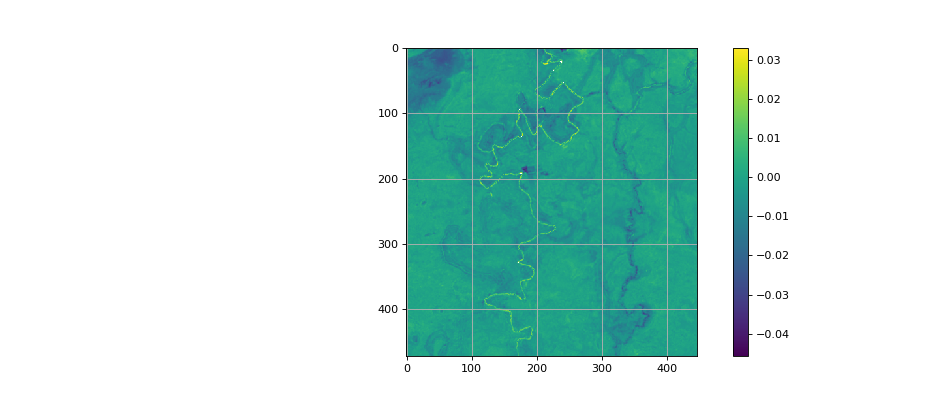

In [59]:
#Run a linear regression on yearly averaged data on the entire grid for a set time interval
    
#Run the above function
time_1 = '2000-01-01'
time_2 = '2008-12-31'

#Prepare the data by cutting it for the  time interval of interest and groubing then averaging 
# it on a yearly basis
cut_data = all_ndvi_sorted.loc[time_1:time_2]
    
ave = cut_data.groupby('time.year').mean(dim='time')   


# Run the linear regression on the grid. This function masks slopes that are statistically insignficant if
# mask_no_tred = True. If you don't want the mask, simply change it to equal False
# The threshold is the minimu
slope_xr, p_val_xr = linear_regression_grid(ave, mask_no_trend = False, threshold = 3)

fig = plt.figure(figsize =(11.69,5))
plt.imshow(slope_xr)

plt.grid(True)
plt.colorbar()

plt.show()


# Saving outputs

In [ ]:
#To save the slope_xr x-array we first convert the data array to a dataset

def add_ds_info(new_ds, old_ds):
    new_ds.attrs['affine'] = old_ds.affine
    new_ds.attrs['crs'] = old_ds.crs


ds = slope_xr.to_dataset(name = 'Slope')

add_ds_info(ds, nbar_clean)



In [ ]:
# To save as a netcdf

outfile = ''

ds.to_netcdf(outfile)

In [ ]:
#Write the files out into a tif file for viewing in GIS

# You may need to adjust the default_profile values so that blockysize is not larger than the xr spatial dimensions

outfile = ''

#Function below is from https://github.com/data-cube/agdc-v2/blob/develop/datacube/helpers.py

DEFAULT_PROFILE = {
    'blockxsize': 128,
    'blockysize': 128,
    'compress': 'lzw',
    'driver': 'GTiff',
    'interleave': 'band',
    'nodata': 0.0,
    'photometric': 'RGBA',
    'tiled': True}


def write_geotiff(filename, dataset, time_index=None, profile_override=None):
    """
    Write an xarray dataset to a geotiff
    :attr bands: ordered list of dataset names
    :attr time_index: time index to write to file
    :attr dataset: xarray dataset containing multiple bands to write to file
    :attr profile_override: option dict, overrides rasterio file creation options.
    """
    profile_override = profile_override or {}

    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes

    profile = DEFAULT_PROFILE.copy()
    profile.update({
        'width': dataset.dims['x'],
        'height': dataset.dims['y'],
        'affine': dataset.affine,
        #'crs': dataset.crs.crs_str,
        'crs': dataset.crs,
        'count': len(dataset.data_vars),
        'dtype': str(dtypes.pop())
    })
    profile.update(profile_override)

    with rasterio.open(filename, 'w', **profile) as dest:
        for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
            #dest.write(data.isel(time=time_index).data, bandnum)
            print bandnum
            print data
            dest.write(data, bandnum)
            print 'Done'
            



write_geotiff(outfile, ds)


